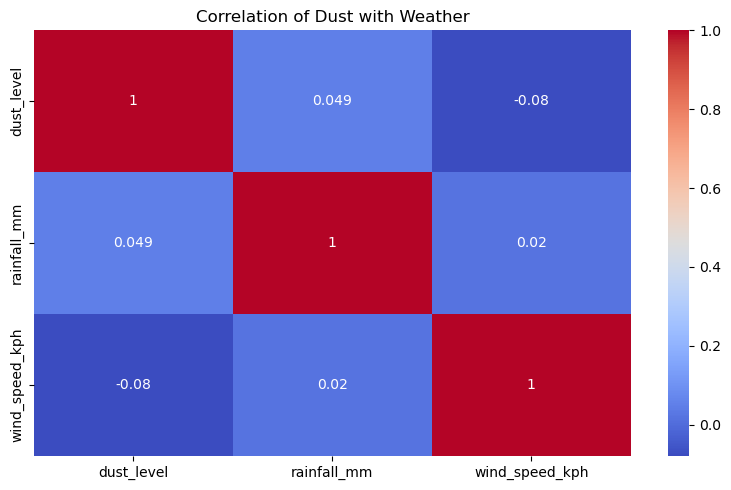

Model RMSE: 27.08 μg/m3


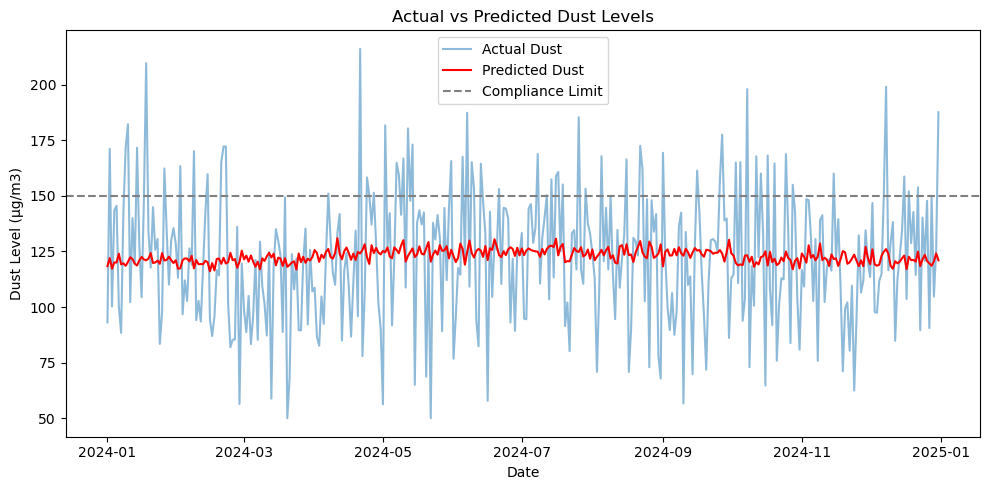

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load datasets
dust = pd.read_csv("dust_data.csv", parse_dates=["date"])
weather = pd.read_csv("weather_data.csv", parse_dates=["date"])

# Merge datasets
df = pd.merge(dust, weather, on="date")

# Add season as a categorical variable
df["month"] = df["date"].dt.month
df["season"] = pd.cut(
    df["month"], bins=[0, 3, 6, 9, 12],
    labels=["Dry", "Wet", "Late Wet", "Late Dry"],
    include_lowest=True
)

# Encode season
df = pd.get_dummies(df, columns=["season"], drop_first=True)

# Drop rows with missing values (if any)
df.dropna(inplace=True)

# Correlation heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(df[["dust_level", "rainfall_mm", "wind_speed_kph"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation of Dust with Weather")
plt.tight_layout()
plt.show()

# Feature selection
features = ["rainfall_mm", "wind_speed_kph"] + [col for col in df.columns if col.startswith("season_")]
X = df[features]
y = df["dust_level"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
df["predicted_dust"] = model.predict(X)
df["high_risk_day"] = df["predicted_dust"] > 150  # Compliance threshold

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
print(f"Model RMSE: {rmse:.2f} μg/m3")

# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(df["date"], df["dust_level"], label="Actual Dust", alpha=0.5)
plt.plot(df["date"], df["predicted_dust"], label="Predicted Dust", color="red")
plt.axhline(150, color='gray', linestyle='--', label="Compliance Limit")
plt.title("Actual vs Predicted Dust Levels")
plt.ylabel("Dust Level (μg/m3)")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()

# Export results
df.to_excel("dust_model_predictions.xlsx", index=False)
